<div style="background-color: darkred; padding: 10px; color: white;">

# Soma Proposal Generation 

</div>

<div style="background-color: darkblue; padding: 10px; color: white;">

<div style="font-size: 20px;">
    We provide an overview of the main routines used to generate soma proposals within a single image patch.<br>
    The objective of this step is to generate initial proposals for potential soma locations by detecting blob-like<br>
    structures in the image. <br><br>

<pre style="background-color: darkblue; color: white; font-family: monospace;">
    Soma Proposal Generation Algorithm<br>
        1. Generate Initial Proposals - detect_blobs()
            a. Smooth image with Gaussian filter to reduce false positives.
            b. Laplacian of Gaussian (LoG) to enhance regions where gradient
               changes rapidly, then apply max filter.
            c. Generate initial set of proposals by detecting local maximas.
            d. Shift each proposal to the brightest voxel in its neighborhood
               and reject it if the brightness is below a threshold.

        2. Filter Initial Proposals - filter_proposals()
            a. Merges proposals within a given distance threshold.
            b. If the number of proposals exceeds a certain threshold, the top
               k brightest proposals are kept.
            c. Fit Gaussian to neighborhood centered at proposal and compute
               fitness score by comparing fitted Gaussian and image values.
               Proposals are discarded if (1) fitness is below threshold or
               (2) estimated standard deviation is out of range.

</pre>
</div>
</div>

## Imports


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings

from random import sample
from skimage.feature import peak_local_max
from scipy.ndimage import gaussian_filter, gaussian_laplace, maximum_filter
from scipy.optimize import curve_fit, OptimizeWarning
from time import time

from aind_exaspim_soma_detection import soma_proposal_generation as spg
from aind_exaspim_soma_detection.utils import img_util, util

warnings.filterwarnings("ignore", category=OptimizeWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
%matplotlib inline


## Subroutines

In [2]:
def gaussian_fitness_filtering(img_patch, proposals, r=4):
    """
    Note: This routine is nearly identical to spg.gaussian_fitness_filtering.
          The difference here is that the rejected proposals are returned and
          we print the following information about each proposal:
          Accept/Reject, brightness, fit_score, estimated std, mean std
    """
    # Main
    accepts = list()
    rejects = list()
    for proposal in proposals:
        # Extract neighborhood
        x0, y0, z0 = tuple(map(int, proposal))
        x_min, x_max = max(0, x0 - r), min(img_patch.shape[0], x0 + r + 1)
        y_min, y_max = max(0, y0 - r), min(img_patch.shape[1], y0 + r + 1)
        z_min, z_max = max(0, z0 - r), min(img_patch.shape[2], z0 + r + 1)
        nbhd = img_patch[x_min:x_max, y_min:y_max, z_min:z_max]

        # Fit Gaussian
        fit, params = spg.gaussian_fitness(nbhd)
        mean, std = params[0:3], params[3:6]

        # Check whether to filter
        proposal = tuple(map(int, proposal))
        feasible_range = all(std > 0.4) and all(std < 10)
        if fit > 0.75 and (feasible_range and np.mean(std) > 0.75):
            print("Accept:", img_patch[proposal], fit, std, np.mean(std))
            proposal = [proposal[i] + mean[i] - r for i in range(3)]
            accepts.append(proposal)
        else:
            print("Reject:", img_patch[proposal], fit, std, np.mean(std))
            rejects.append(proposal)
    return accepts, rejects

## Initializations

In [3]:
# Parameters
bucket_name = "aind-open-data"
brain_id = "737563"
multiscale = 4
bright_threshold = 140
d = 16  # image margin

# Open img
img_prefixes = util.read_json("/root/capsule/data/exaspim_image_prefixes.json")
img = img_util.open_img(img_prefixes[brain_id] + str(multiscale))
print("Image Shape:", img.shape)

Image Shape: (1, 1, 1805, 1812, 3895)


## Main

Accept: 174 0.9532471966709475 [0.92759738 0.64509035 0.75913923] 0.7772756530215138

# Proposals: 1
# Rejects: 0
Runtime: 0.18796396255493164


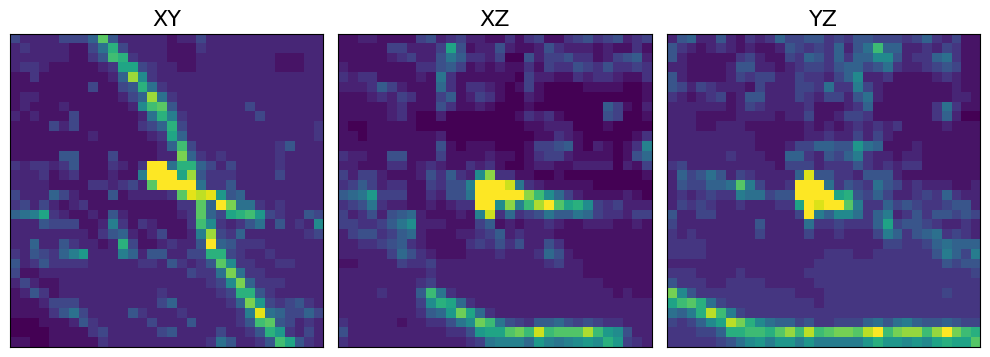

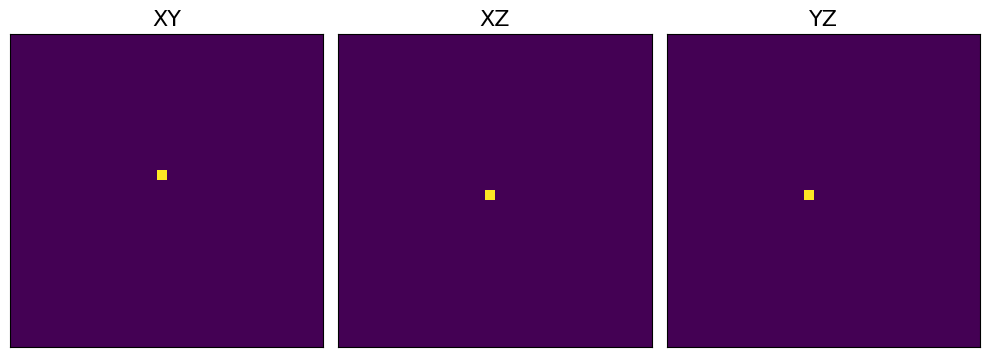

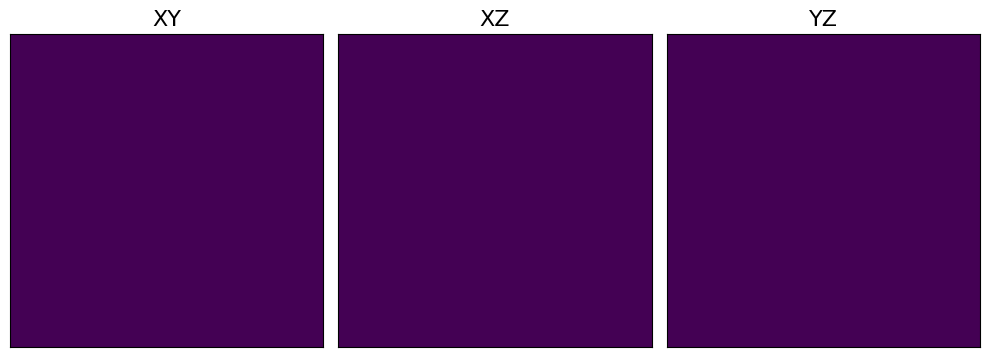

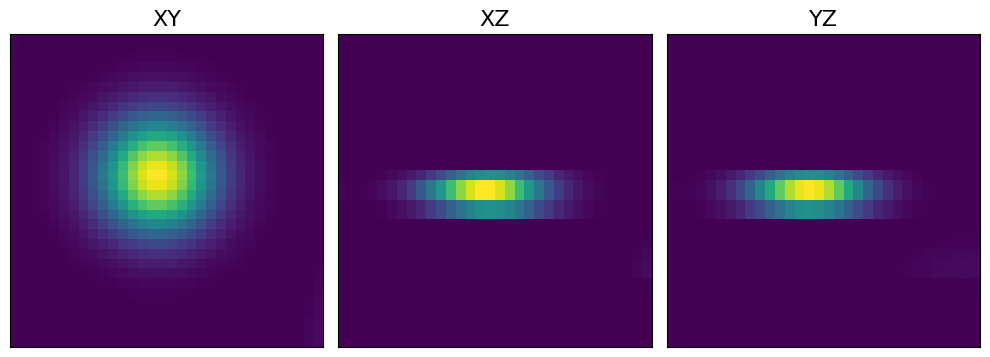

In [9]:
# Region of Interest
xyz = [14436.505,12110.707,7347.7085]
patch_shape = [64, 64, 64]

# Read Image Patch
voxel = img_util.to_voxels(xyz, multiscale)
img_patch = img_util.get_patch(img, voxel, patch_shape)
t0 = time()

# Step 1: Generate Initial Proposals
img_patch = gaussian_filter(img_patch, sigma=0.5)
proposals_1 = spg.detect_blobs(img_patch, bright_threshold, 8, d)
proposals_2 = spg.detect_blobs(img_patch, bright_threshold, 5, d)
proposals_3 = spg.detect_blobs(img_patch, bright_threshold, 3.25, d)
proposals = proposals_1 + proposals_2 + proposals_3

# Step 2: Filter Initial Proposals
proposals = spg.spatial_filtering(proposals, 5)
proposals = spg.brightness_filtering(img_patch, proposals, 10)
proposals, rejects = gaussian_fitness_filtering(img_patch, proposals)

# Report Results
print("\n# Proposals:", len(proposals))
print("# Rejects:", len(rejects))
print("Runtime:", time() - t0)

# Visualize Results
proposals_img = img_util.get_detections_img(patch_shape, proposals)
rejects_img = img_util.get_detections_img(patch_shape, rejects)
LoG = gaussian_laplace(img_patch, 4)

img_util.plot_mips(img_patch[d:-d, d:-d, d:-d], clip_bool=True)
img_util.plot_mips(proposals_img[d:-d, d:-d, d:-d])
img_util.plot_mips(rejects_img[d:-d, d:-d, d:-d])
img_util.plot_mips(LoG[d:-d, d:-d, d:-d])

## Visualize Gaussian Fit

Fitness Score: 0.9532471966709475
Esimated Parameters: [  4.2100941    4.47282509   4.28133228   0.92759738   0.64509035
   0.75913923 175.968108     9.99324604]


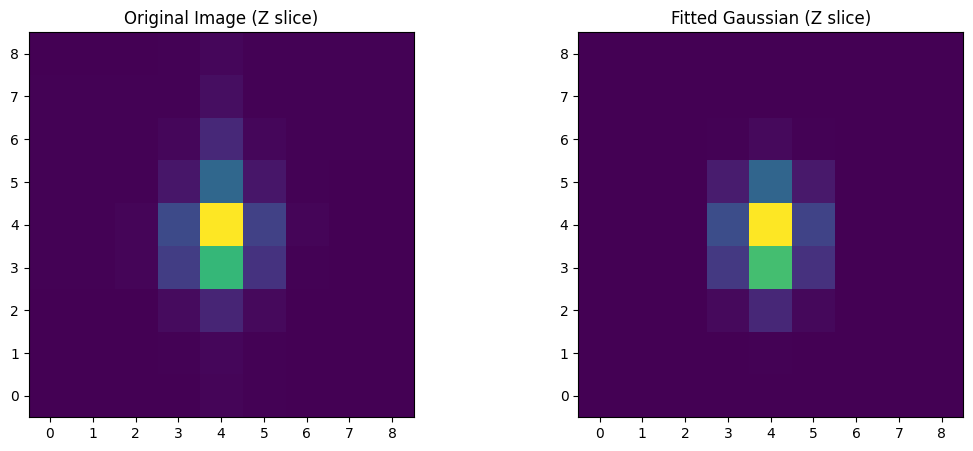

In [7]:
# Parameters
margin = 16
r = 4

# Get valid center
while True:
    voxel = sample(proposals + rejects, 1)[0]
    if spg.is_inbounds(img_patch.shape, voxel, margin=margin):
        break

# Get patch from img
x0, y0, z0 = tuple(map(int, voxel))
x_min, x_max = max(0, x0 - r), min(img_patch.shape[0], x0 + r + 1)
y_min, y_max = max(0, y0 - r), min(img_patch.shape[1], y0 + r + 1)
z_min, z_max = max(0, z0 - r), min(img_patch.shape[2], z0 + r + 1)
nbhd = img_patch[x_min:x_max, y_min:y_max, z_min:z_max]

# Initialize parameters guess
shape = nbhd.shape
x0, y0, z0 = shape[0] // 2, shape[1] // 2, shape[2] // 2
p0 = (x0, y0, z0, 2, 2, 2, np.max(nbhd), np.min(nbhd))

# Fit Gaussian
try:
    img_vals = nbhd.ravel()
    voxels = spg.generate_grid_coords(nbhd.shape)
    params, _ = curve_fit(spg.gaussian_3d, voxels, img_vals, p0=p0)
except RuntimeError:
    params = np.zeros((9))

# Fitness quality
print("Fitness Score:", spg.fitness_score(nbhd, voxels, params))
print("Esimated Parameters:", params)

# Visualize image patch
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
axs[0].imshow(nbhd[:, :, z0], cmap='viridis', origin='lower')
axs[0].set_title("Original Image (Z slice)")

# Visualize fitted gaussian
if params is not None:
    fitted_blob = spg.gaussian_3d((x, y, z), *params).reshape(x.shape)
    axs[1].imshow(fitted_blob[:, :, z0], cmap='viridis', origin='lower')
    axs[1].set_title("Fitted Gaussian (Z slice)")